# The Assignment Objective #

##### Download the file and set it as a Dataframe. (1 Marks) #####
##### Remove punctuations, special characters and stopwords from the text column. Convert the text to lower case. (3 Marks) #####
##### Create two objects X and y. X will be the ' reviewText ' column dataframe and y will be the “Overall Rating” column. create a CountVectorizer object and split the data into training and testing sets. Train a MultinomialNB model and Display the confusion Matrix (5 Marks) #####
##### Display the POS tagging on the first 4 rows of ‘reviewText’ (4 Marks) #####
##### Build and display a dependency parser tree for the sentence: #####
##### “He staunchly opposes Jon's proposal to allow the wildlings to pass through the Wall before the White Walkers reach them and later participates in the mutiny against Jon, being the second to stab him.” (2 Marks) #####

### Importing the libraries ###

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM

### A1 . Reading the data and setting it as a dataframe ###

In [102]:
df = pd.read_csv("kindle_reviews.csv")
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


### A2. Removing punctuations, special characters and stopwords from the text column and converting the text to lower case ###

#### It would be costly yet unnecessary to conduct the text operations (Removing punctuation, stopwords and conversion to lower case) on the entire dataframe. Hence trimming and preprocessing the dataframe before doing those operations ####

##### Heat Map Analysis to understand the dependencies #####

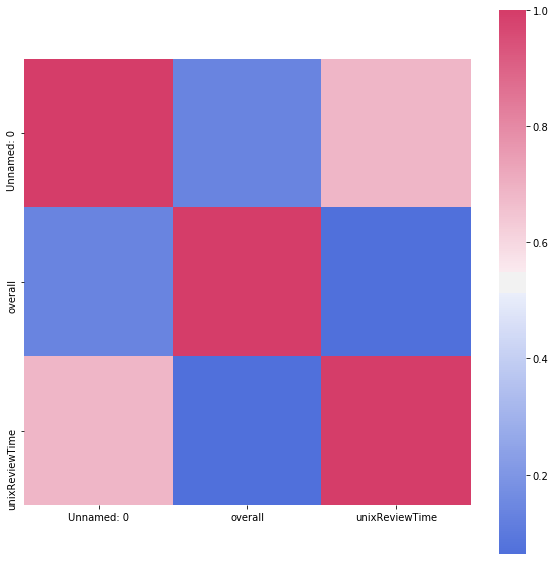

In [103]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

##### Deleting columns which are not required #####

In [104]:
del df['Unnamed: 0']
del df['asin']
del df['helpful']
del df['reviewTime']
del df['reviewerID']
del df['reviewerName']
del df['unixReviewTime']

##### Checking the missing values and count #####

In [105]:
df.isna().sum()

overall        0
reviewText    22
summary        1
dtype: int64

In [106]:
df.overall.count()

982619

In [89]:
df.head()

,overall,reviewText,summary
0,5,I enjoy vintage books and movies so I enjoyed ...,Nice vintage story
1,4,This book is a reissue of an old one; the auth...,Different...
2,4,This was a fairly interesting read. It had ol...,Oldie
3,5,I'd never read any of the Amy Brewster mysteri...,I really liked it.
4,4,"If you like period pieces - clothing, lingo, y...",Period Mystery


##### Appending Summary to the Review Text and deleting Summary column #####

In [90]:
df['reviewText'] = df['reviewText'] + ' ' + df['summary']
del df['summary']

In [91]:
df.isna().sum()

overall        0
reviewText    23
dtype: int64

##### Replacing missing values with "" #####

In [92]:
df['reviewText'].fillna("",inplace = True)
df.head()

,overall,reviewText
0,5,I enjoy vintage books and movies so I enjoyed ...
1,4,This book is a reissue of an old one; the auth...
2,4,This was a fairly interesting read. It had ol...
3,5,I'd never read any of the Amy Brewster mysteri...
4,4,"If you like period pieces - clothing, lingo, y..."


#### Removing stopwords, punctuation marks and converting the text to lower case to the reviewText column. Please note, reviewText column is appended value of reviewText and summary columns ####

In [113]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def clean_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = i.strip().lower()
            final_text.append(word)
    return " ".join(final_text)

df['reviewText'] = df['reviewText'].apply(clean_text)

df.head()

,overall,reviewText
0,5,enjoy vintage books movies enjoyed reading boo...
1,4,book reissue old one; author born 1910. era of...
2,4,fairly interesting read. old- style terminolog...
3,5,i'd never read amy brewster mysteries one.. re...
4,4,"like period pieces clothing, lingo, enjoy myst..."


### A3. Creating two objects X and y. X will be the ' reviewText ' column dataframe and y will be the 'Overall' (Overall Rating) column. Creating a CountVectorizer object and splitting the data into training and testing sets. Training the MultinomialNB model and Displaying the confusion Matrix ###

##### Printing the counts in each review category #####

In [114]:
df.overall.value_counts()

5    575264
4    254013
3     96194
2     34130
1     23018
Name: overall, dtype: int64

#### Replacing review category with Good (1) and Not Good(0) and calculating counts in each Good (1) and Not Good (0) category ####

In [115]:
def review_sentiment(rating):
    # Replacing rating of 1,2,3 with 0(not good) and 4,5 with 1(good) 
    if(rating == 1 or rating == 2 or rating == 3):
        return 0
    else:
        return 1

df.overall = df.overall.apply(review_sentiment)

df.overall.value_counts()

1    829277
0    153342
Name: overall, dtype: int64

##### Train-Test Split #####

In [117]:
x_train,x_test,y_train,y_test = train_test_split(df.reviewText,df.overall ,random_state = 0)

##### Creating the Count Vectorizer #####

In [118]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,1))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (736964, 135828)
BOW_cv_test: (245655, 135828)


##### Creating the multinomial Naive Bayes model and training the model #####

In [119]:
mnb = MultinomialNB()
mnb.fit(cv_train_reviews,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##### Testing the model and calculating the accuracy #####

In [120]:
mnb_pred = mnb.predict(cv_test_reviews)
accuracy_score(y_test,mnb_pred)

0.8431295923144247

##### Printing the classification report #####

In [121]:
cv_report = classification_report(y_test,mnb_pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.27      0.00      0.00     38383
           1       0.84      1.00      0.91    207272

    accuracy                           0.84    245655
   macro avg       0.56      0.50      0.46    245655
weighted avg       0.75      0.84      0.77    245655



##### Printing the confusion matrix #####

In [122]:
cm_cv = confusion_matrix(y_test,mnb_pred)
print(cm_cv)

[[    89  38294]
 [   242 207030]]


##### Plotting the Output #####

In [123]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

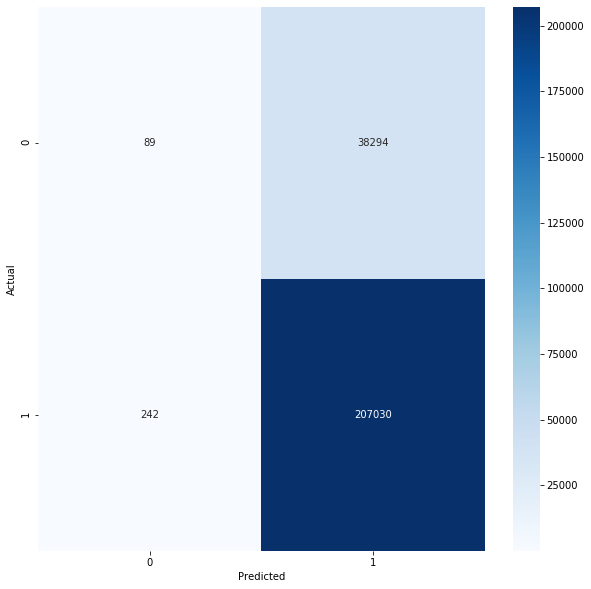

In [124]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

### A4. POS tagging of first 4 rows ###

In [125]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

for i in df.reviewText.head(4) :
      
    # Word tokenizers is used to find the words 
    # and punctuation in a string
    wordsList = nltk.word_tokenize(i)
  
    # removing stop words from wordList
    wordsList = [w for w in wordsList if not w in stop_words] 
  
    #  Using a Tagger. Which is part-of-speech 
    # tagger or POS-tagger. 
    tagged = nltk.pos_tag(wordsList)
  
    print(tagged)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\amits\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('enjoy', 'NN'), ('vintage', 'NN'), ('books', 'NNS'), ('movies', 'NNS'), ('enjoyed', 'VBD'), ('reading', 'VBG'), ('book', 'NN'), ('.', '.'), ('plot', 'NN'), ('unusual', 'JJ'), ('.', '.'), ('think', 'VB'), ('killing', 'VBG'), ('someone', 'NN'), ('self-defense', 'JJ'), ('leaving', 'VBG'), ('scene', 'NN'), ('body', 'NN'), ('without', 'IN'), ('notifying', 'VBG'), ('police', 'NN'), ('hitting', 'VBG'), ('someone', 'NN'), ('jaw', 'NN'), ('knock', 'NN'), ('would', 'MD'), ('wash', 'VB'), ('today.still', 'RB'), ('good', 'JJ'), ('read', 'NN'), ('.', '.'), ('nice', 'JJ'), ('vintage', 'NN'), ('story', 'NN')]
[('book', 'NN'), ('reissue', 'NN'), ('old', 'JJ'), ('one', 'CD'), (';', ':'), ('author', 'NN'), ('born', 'VBD'), ('1910.', 'CD'), ('era', 'NN'), (',', ','), ('say', 'VBP'), (',', ','), ('nero', 'JJ'), ('wolfe', 'NN'), ('.', '.'), ('introduction', 'NN'), ('quite', 'RB'), ('interesting', 'JJ'), (',', ','), ('explaining', 'VBG'), ('author', 'NN'), ("'s", 'POS'), ('forgotten', 'NN'), (';', ':'), (

### A5. Dependency parsing of the given sentence ###

In [126]:
import spacy
from spacy import displacy

nlp=spacy.load('en_core_web_sm')

text='He staunchly opposes Jon\'s proposal to allow the wildlings to pass through the Wall before the White Walkers reach them and later participates in the mutiny against Jon, being the second to stab him.'

for token in nlp(text):
    print(token.text,'=>',token.dep_,'=>',token.head.text)

displacy.render(nlp(text),jupyter=True)

He => nsubj => opposes
staunchly => advmod => opposes
opposes => ROOT => opposes
Jon => poss => proposal
's => case => Jon
proposal => dobj => opposes
to => aux => allow
allow => acl => proposal
the => det => wildlings
wildlings => nsubj => pass
to => aux => pass
pass => ccomp => allow
through => prep => pass
the => det => Wall
Wall => pobj => through
before => mark => reach
the => det => Walkers
White => compound => Walkers
Walkers => nsubj => reach
reach => advcl => pass
them => dobj => reach
and => cc => reach
later => advmod => participates
participates => conj => reach
in => prep => participates
the => det => mutiny
mutiny => pobj => in
against => prep => mutiny
Jon => pobj => against
, => punct => participates
being => advcl => participates
the => det => second
second => attr => being
to => aux => stab
stab => relcl => second
him => dobj => stab
. => punct => opposes
